In [ ]:
 import tensorflow as tf
 from tensorflow.keras.layers import Dense, Flatten
 from tensorflow.keras.models import Model
 from tensorflow.keras.optimizers import Adam
 from keras.applications.vgg16 import VGG16,preprocess_input, decode_predictions
 from keras.preprocessing import image as keras_image

In [ ]:
# Load VGG16 pre-trained on ImageNet without the top layer(classification layer)
base_model = VGG16(weights='imagenet', include_top=False,input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
# Freeze all the layers in the base model
for layer in base_model.layers:#weight values donot affect the
  layer.trainable = False

In [ ]:
# Create custom layers for our new classification task
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation = 'relu')(x)
predictions = Dense(3, activation='softmax')(x)

In [ ]:
# Combine the original model with the new layers
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
from skimage import io
from PIL import Image

In [ ]:
X=[]
Y=[]
base_path='/content/gdrive/My Drive/new'
source_path=base_path
for child in os.listdir(source_path):
  print(child)
  sub_path = os.path.join(source_path, child)
  bsub_path = os.path.join(base_path, child)
  if os.path.isdir(sub_path):
    for data_file in os.listdir(sub_path):
      Qry = Image.open(os.path.join(sub_path, data_file))
      Qry = Qry.convert("RGB")
      Qry = np.array(Qry.resize((224,224)))
      Qry = Qry.reshape([224,224,3])
      flist=np.array(Qry)
      X.append(flist)
      Y.append(child)

Covid
NORMAL
PNEUMONIA


In [ ]:
images_arr = np.asarray(X)
images_arr = images_arr.astype('float32')
images_arr = images_arr / np.max(images_arr)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
labelBinarizer = LabelBinarizer()
y=labelBinarizer.fit_transform(Y)

In [ ]:

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test =train_test_split(images_arr,y,test_size=0.2,random_state=42,stratify=y)

In [ ]:
# Train the model on your new dataset
model.fit(X_train, y_train, epochs=30, validation_data=(X_test,y_test))

Epoch 1/30
21/21 [==============================] - 23s 601ms/step - loss: 0.5669 - accuracy: 0.7967 - val_loss: 0.1959 - val_accuracy: 0.9464
Epoch 2/30
21/21 [==============================] - 4s 204ms/step - loss: 0.1010 - accuracy: 0.9686 - val_loss: 0.1562 - val_accuracy: 0.9524
Epoch 3/30
21/21 [==============================] - 4s 197ms/step - loss: 0.0529 - accuracy: 0.9865 - val_loss: 0.1381 - val_accuracy: 0.9524
Epoch 4/30
21/21 [==============================] - 3s 163ms/step - loss: 0.0302 - accuracy: 0.9970 - val_loss: 0.1351 - val_accuracy: 0.9583
Epoch 5/30
21/21 [==============================] - 4s 196ms/step - loss: 0.0207 - accuracy: 0.9970 - val_loss: 0.1270 - val_accuracy: 0.9583
Epoch 6/30
21/21 [==============================] - 4s 174ms/step - loss: 0.0313 - accuracy: 0.9895 - val_loss: 0.1691 - val_accuracy: 0.9583
Epoch 7/30
21/21 [==============================] - 4s 196ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.1530 - val_accuracy: 0.9583
Epoch

In [ ]:
testLoss, testAccuracy = model.evaluate(X_test,y_test)
print("Test Accuracy =", testAccuracy)

6/6 [==============================] - 1s 115ms/step - loss: 0.1943 - accuracy: 0.9583
Test Accuracy = 0.9583333134651184


In [ ]:
model.save('VGG16_LIME.keras')

from tensorflow.keras.models import load_model
vgg_model = load_model("VGG16_LIME.keras")

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

img_path = "/content/gdrive/MyDrive/new/NORMAL/IM-0005-0001.jpeg"

In [ ]:
def load_and_preprocess_image(image_path):
  # Open the image file
  img = Image.open(image_path)

  # Resize the image to the desired input size (e.g., 128x128)
  img = img.resize((224, 224))

  # Convert image to numpy array and normalize pixel values to [0, 1]
  img_array = np.array(img) / 255.0

  return img_array

In [ ]:
# Load and preprocess the image
image_array = load_and_preprocess_image(img_path)

In [ ]:
!pip install lime

In [ ]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [ ]:
explanation =explainer.explain_instance(image_array.astype('double'),vgg_model.predict, top_labels=2, hide_color=0,num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


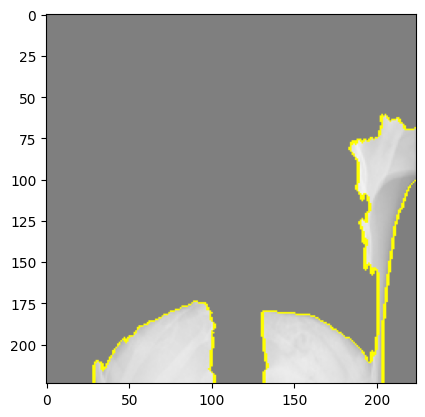

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
temp, mask =explanation.get_image_and_mask(explanation.top_labels[0],positive_only=True, num_features=3, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

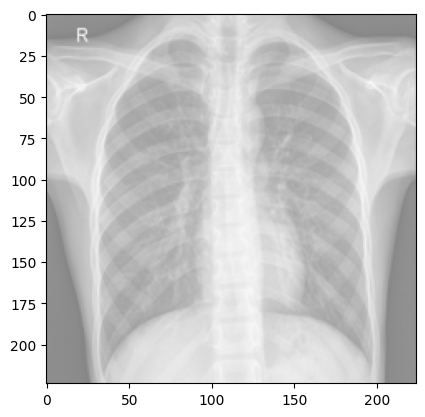

In [ ]:
temp, mask =explanation.get_image_and_mask(explanation.top_labels[0],positive_only=False, num_features=1000, hide_rest=False,min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

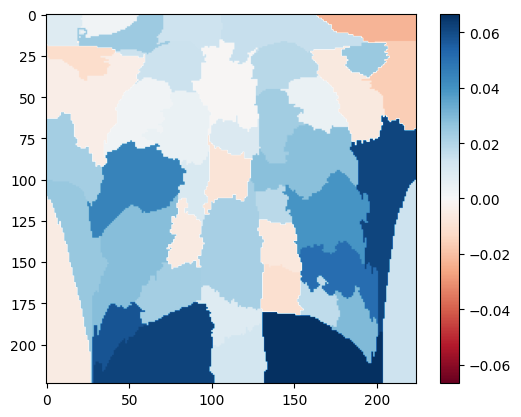

In [ ]:
#Select the same class explained on the figures above.
ind = explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin = -heatmap.max(), vmax =heatmap.max())#color full image using heatmap
plt.colorbar()

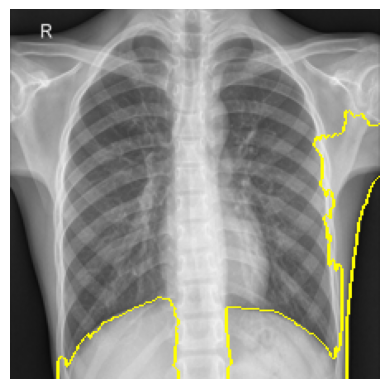

In [ ]:
from skimage.segmentation import mark_boundaries

# Get the explanation for the top class
temp, mask =explanation.get_image_and_mask(explanation.top_labels[0],positive_only=True, num_features=3, hide_rest=False)
plt.imshow(mark_boundaries(image_array, mask))
plt.axis('off')
plt.show()

In [ ]:
#